# Analyzing replicability of functional connectivity-based multivariate BWAS on the Human Connectome Project dataset

Comprehensive analysis with 52 HCP phenotypes

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from mlxtend.evaluate import permutation_test
sns.set(rc={"figure.figsize":(4, 2)})
sns.set_style("whitegrid")

## Load HCP data

We load functional network matrices (netmats) from the HCP1200-release, as published on connectomeDB: https://db.humanconnectome.org/
Due to licensing issues, data is not supplied with the repository, but can be downloaded from the ConnectomeDB or via `get_data.ipynb` (requires credentials).
See [readme.md](readme.md) for more details.

In [2]:
# HCP data can be obtained from the connectomeDB
# data is not part of this repository
subjectIDs = pd.read_csv('hcp_data/subjectIDs.txt', header=None)

netmats_pearson = pd.read_csv('hcp_data/netmats1_correlationZ.txt',
                             sep=' ',
                             header=None)
netmats_pearson['ID'] = subjectIDs[0]
netmats_pearson.set_index('ID', drop=True, inplace=True)


netmats_parcor = pd.read_csv('hcp_data/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)

behavior = pd.read_csv('hcp_data/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age
behavior.describe()

,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_tMRI_PctCompl,fMRI_WM_PctCompl,fMRI_Gamb_PctCompl,fMRI_Mot_PctCompl,fMRI_Lang_PctCompl,fMRI_Soc_PctCompl,...,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,age
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,...,1204.000000,1204.000000,1201.000000,1205.000000,1200.000000,1200.000000,1198.000000,1195.000000,1195.000000,1206.000000
mean,1.478441,1.400498,3.509950,87.213267,88.219569,89.718076,89.852736,89.631675,87.027114,87.039801,...,110.421321,97.727500,1.449625,45.847718,95.166983,93.998533,1.845467,0.581590,1.822251,28.904229
std,0.635688,0.628216,1.215181,31.027886,29.942161,30.384864,30.163559,30.492092,33.566043,33.570248,...,9.107963,11.273251,1.783069,7.679288,14.583412,14.837851,0.541393,0.973172,0.542893,3.570475
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.740000,59.860000,0.000000,38.600000,56.350000,59.500000,1.560000,0.000000,1.080000,23.500000
25%,1.000000,1.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,101.120000,87.110000,0.000000,38.600000,84.070000,83.220000,1.800000,0.000000,1.760000,28.000000
50%,2.000000,1.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,108.790000,98.040000,1.000000,45.900000,95.360000,94.970000,1.800000,0.000000,1.800000,28.000000
75%,2.000000,2.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,122.250000,110.450000,2.000000,52.200000,105.570000,102.920000,1.880000,1.000000,1.840000,33.000000
max,2.000000,2.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,122.250000,111.410000,10.000000,75.300000,134.650000,131.380000,15.000000,17.000000,15.000000,36.000000


# Helper function to prepare target variable


In [3]:
def create_data(target='CogTotalComp_AgeAdj', feature_data=netmats_parcor):
    # it's a good practice to use pandas for merging, messing up subject order can be painful
    features = feature_data.columns
    df = behavior
    df = df.merge(feature_data, left_index=True, right_index=True, how='left')

    df = df.dropna(subset = [target] + features.values.tolist())
    y = df[target].values
    X = df[features].values
    return X, y

# Helper function implementing a single bootstrap iteration

We define a workhorse function which:
- randomly samples the discovery and the replication datasets,
- creates cross-validated estimates of predictive performance within the discovery sample
- finalizes the model by fitting it to the whole discovery sample (overfits the discovery but not the replication sample)
- use it to predict the replication sample

In [4]:
def corr(X, Y):
    # just a small wrapper function (pandas correlation is silent in "unlucky" bootstraps with constant values)
    return pd.Series(X).corr( pd.Series(Y))

def bootstrap_workhorse(X, y, sample_size, model, random_state, shuffle_y=False):

    #create discovery and replication samples by random sampling from the whole dataset (without replacement)

    # if shuffle_y is true, a null model is created bz permuting y
    if shuffle_y:
        rng = np.random.default_rng(random_state)
        y = rng.permutation(y)

    # sample the discovery and replication sets *without replacement* (with replacement introduces spurious dependencies)
    X_discovery, X_replication, y_discovery, y_replication = train_test_split(X, y, train_size=sample_size, test_size=sample_size, shuffle=True, random_state=random_state)

    # standard 10-fold cross-validation
    cv = KFold(10)

    # below we obtain cross-validated predictions in the discovery sample
    predicted_discovery_cv = np.zeros_like(y_discovery)  # here we collect the predictions for each fold
    cor_per_fold = np.zeros(cv.n_splits)  # here we collect the predictive performance in each fold
    i = 0  # just a counter
    for train, test in cv.split(X=X_discovery, y=y_discovery):  # loop to leave one fold out
        model.fit(X=X_discovery[train], y=y_discovery[train]) # fit model to the training set
        predicted_discovery_cv[test] = model.predict(X=X_discovery[test]) # use fitted model to predict teh test set
        cor_per_fold[i] = corr(y_discovery[test], predicted_discovery_cv[test]) # calculate performance on tne test set
        i += 1
    # calculate mean test performance across all folds
    r_disc_cv = np.mean(cor_per_fold)
    # 'finalize' model by training it on the full discovery sample (without cross-validation)
    final_model = model.fit(X=X_discovery, y=y_discovery)
    # obtain predictions with the final model on the discovery sample, note that this model actually overfits this sample.
    # we do this only to demonstrate biased estimates
    predicted_discovery_overfit = final_model.predict(X=X_discovery)
    # here we obtain the biased effect size (r) estimates for demonstrational purposes
    r_disc_overfit = corr(predicted_discovery_overfit, y_discovery)

    # We use the final model to predict the replication sample
    # This is correct (no overfitting here), the final model did not see this data during training
    predicted_replication = final_model.predict(X=X_replication)
    # we obtain the out-of-sample prediction performance estimates
    r_rep = corr(predicted_replication, y_replication)

    # below we calculate permutation-based p-values for all three effect size estimates (in-sample unbiased, in-sample biased, out-of-sample)
    # (one sided tests, testing for positive correlation)
    p_disc_cv = permutation_test(predicted_discovery_cv, y_discovery, method='approximate', num_rounds=1000, func=lambda x, y: corr(x, y),seed=random_state)
    p_disc_overfit = permutation_test(predicted_discovery_overfit, y_discovery, method='approximate', num_rounds=1000, func=lambda x, y: corr(x, y),seed=random_state)
    p_rep = permutation_test(predicted_replication, y_replication, method='approximate', num_rounds=1000, func=lambda x, y: corr(x, y),seed=random_state)
    # return results
    return r_disc_cv, r_disc_overfit, r_rep, p_disc_cv, p_disc_overfit, p_rep

All set, now we start the analysis.

# Replicability with sample sizes n=50, 100, 200, 300 and max
Here we train a few different models on 100 bootstrap samples.

We aggregate the results of our workhorse function in `n_bootstrap`=100 bootstrap cases (run in parallel).

The whole process is repeated for all sample sizes, fetaure_sets and target variables.

## Here we test all 33 variables, proposed by Marek et al. in their response.

In [5]:
targets = [
#demographics
    'age',
# cognition
    'MMSE_Score',
    'PSQI_Score',
    'PicSeq_AgeAdj',
    'CardSort_AgeAdj',
    'Flanker_AgeAdj',
    'PMAT24_A_CR',
    'CogFluidComp_AgeAdj',
    'CogCrystalComp_AgeAdj',
    'CogEarlyComp_AgeAdj',
    'CogTotalComp_AgeAdj',
    'ReadEng_AgeAdj',
    'PicVocab_AgeAdj',
    'ProcSpeed_AgeAdj',
    'DDisc_AUC_200',
    'VSPLOT_TC',
    'SCPT_SEN',
    'SCPT_SPEC',
# memory
    'IWRD_TOT',
    'ListSort_AgeAdj',
# emotion
    'ER40ANG',
    'ER40FEAR',
    'ER40HAP',
    'ER40NOE',
    'ER40SAD',
    'AngAffect_Unadj',
    'AngHostil_Unadj',
    'AngAggr_Unadj',
    'FearAffect_Unadj',
    'FearSomat_Unadj',
    'FearSomat_Unadj',
    'Sadness_Unadj',
    'LifeSatisf_Unadj',
    'MeanPurp_Unadj',
    'PosAffect_Unadj',
    'Friendship_Unadj',
    'Loneliness_Unadj',
    'PercHostil_Unadj',
    'PercReject_Unadj',
    'EmotSupp_Unadj',
    'InstruSupp_Unadj',
    'PercStress_Unadj',
    'SelfEff_Unadj',
    'Dexterity_AgeAdj',
 # personality
    'NEOFAC_A',
    'NEOFAC_O',
    'NEOFAC_C',
    'NEOFAC_N',
    'NEOFAC_E',
# sensory
    'Noise_Comp',
    'Odor_AgeAdj',
    'PainInterf_Tscore',
    'Taste_AgeAdj',
    'Mars_Final'
]

# Now we fit a simple Ridge regression
(no feature selection, no hyperparameter optimization)

In [6]:
%%time

random_state = 42
n_bootstrap = 100

features = {
    'netmats_parcor': netmats_parcor#,
    #'netmats_pearson': netmats_pearson
}

models = {
    'ridge': Ridge()
}

# We aggregate all results here:
df = pd.DataFrame(columns=['connectivity','model','target','n','r_discovery_cv','r_discovery_overfit','r_replication','p_discovery_cv','p_discovery_overfit','p_replication'])

for feature_set in features:
    for model in models:
        for target_var in targets:
            for sample_size in ['max']:

                print('*****************************************************************')
                print(feature_set, model, target_var, sample_size)

                X, y = create_data(target=target_var, feature_data=features[feature_set])

                if sample_size=='max':
                    sample_size = int(len(y)/2)

                # create random seeds for each bootstrap iteration for reproducibility
                rng = np.random.default_rng(random_state)
                random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)

                # run bootstrap iterations in parallel
                r_discovery_cv, r_discovery_overfit, r_replication, p_discovery_cv, p_discovery_overfit, p_replication = zip(
                    *Parallel(n_jobs=-1)(
                    delayed(bootstrap_workhorse)(X, y, sample_size, models[model], seed) for seed in random_sates))

                tmp_data_frame = pd.DataFrame({
                    'connectivity' : feature_set,
                    'model' : model,
                    'target' : target_var,
                    'n' : sample_size,
                    'r_discovery_cv': r_discovery_cv,
                    'r_discovery_overfit': r_discovery_overfit,
                    'r_replication': r_replication,
                    'p_discovery_cv': p_discovery_cv,
                    'p_discovery_overfit': p_discovery_overfit,
                    'p_replication': p_replication
                })
                #sns.scatterplot(x='r_replication', y='r_discovery_cv', data=tmp_data_frame)
                #plt.ylabel('in-sample (r)')
                #plt.xlabel('out-of-sample (r_pred)')
                #plt.show()
                print('r discovery (with cv) :', tmp_data_frame.r_discovery_cv.mean(), 'r replication:', tmp_data_frame.r_replication.mean())

                for alpha in [0.05, 0.01, 0.005, 0.001]:
                    print('Replicability at alpha =', alpha, ':',
                          (tmp_data_frame.loc[tmp_data_frame['p_discovery_cv']<alpha,'p_replication']<alpha).sum() / (tmp_data_frame['p_discovery_cv']<0.05).sum() * 100, '%')

                df = pd.concat((df, tmp_data_frame))
                df.reset_index(drop=True, inplace=True)
                df.to_csv('res/revised_results_Ridge.csv')

df


*****************************************************************
netmats_parcor ridge age max
r discovery (with cv) : 0.48020846359551633 r replication: 0.48967065593640496
Replicability at alpha = 0.05 : 100.0 %
Replicability at alpha = 0.01 : 100.0 %
Replicability at alpha = 0.005 : 100.0 %
Replicability at alpha = 0.001 : 100.0 %
*****************************************************************
netmats_parcor ridge MMSE_Score max
r discovery (with cv) : 0.11235242553787785 r replication: 0.12970357972616348
Replicability at alpha = 0.05 : 89.87341772151899 %
Replicability at alpha = 0.01 : 40.50632911392405 %
Replicability at alpha = 0.005 : 25.31645569620253 %
Replicability at alpha = 0.001 : 2.5316455696202533 %
*****************************************************************
netmats_parcor ridge PSQI_Score max
r discovery (with cv) : 0.14291306988028807 r replication: 0.14519995923911966
Replicability at alpha = 0.05 : 98.85057471264368 %
Replicability at alpha = 0.01 : 72.4137

<timed exec>:58: RuntimeWarning: invalid value encountered in long_scalars


r discovery (with cv) : 0.05015028148085295 r replication: 0.05477097859212915
Replicability at alpha = 0.05 : 16.666666666666664 %
Replicability at alpha = 0.01 : 0.0 %
Replicability at alpha = 0.005 : 0.0 %
Replicability at alpha = 0.001 : 0.0 %
*****************************************************************
netmats_parcor ridge ER40SAD max
r discovery (with cv) : 0.03355879047628217 r replication: 0.043958511763540556
Replicability at alpha = 0.05 : 10.0 %
Replicability at alpha = 0.01 : 0.0 %
Replicability at alpha = 0.005 : 0.0 %
Replicability at alpha = 0.001 : 0.0 %
*****************************************************************
netmats_parcor ridge AngAffect_Unadj max
r discovery (with cv) : 0.09675041204325666 r replication: 0.097384559509148
Replicability at alpha = 0.05 : 69.23076923076923 %
Replicability at alpha = 0.01 : 12.307692307692308 %
Replicability at alpha = 0.005 : 1.5384615384615385 %
Replicability at alpha = 0.001 : 0.0 %
************************************

,connectivity,model,target,n,r_discovery_cv,r_discovery_overfit,r_replication,p_discovery_cv,p_discovery_overfit,p_replication
0,netmats_parcor,ridge,age,501,0.480679,1.0,0.514760,0.000999,0.000999,0.000999
1,netmats_parcor,ridge,age,501,0.477272,1.0,0.455021,0.000999,0.000999,0.000999
2,netmats_parcor,ridge,age,501,0.528641,1.0,0.482612,0.000999,0.000999,0.000999
3,netmats_parcor,ridge,age,501,0.488856,1.0,0.502899,0.000999,0.000999,0.000999
4,netmats_parcor,ridge,age,501,0.429166,1.0,0.530274,0.000999,0.000999,0.000999
...,...,...,...,...,...,...,...,...,...,...
5395,netmats_parcor,ridge,Mars_Final,499,0.090619,1.0,0.031658,0.069930,0.000999,0.115884
5396,netmats_parcor,ridge,Mars_Final,499,0.005679,1.0,0.038146,0.565435,0.000999,0.147852
5397,netmats_parcor,ridge,Mars_Final,499,0.017233,1.0,0.057484,0.449550,0.000999,0.106893
5398,netmats_parcor,ridge,Mars_Final,499,0.009701,1.0,0.005276,0.526474,0.000999,0.400599


In [7]:
df.groupby(['connectivity', 'model', 'target', 'n']).mean()[['r_discovery_cv', 'r_replication']]

r_discovery_cv  r_replication
connectivity   model target                n                                 
netmats_parcor ridge AngAffect_Unadj       501        0.096750       0.097385
                     AngAggr_Unadj         501        0.194056       0.200524
                     AngHostil_Unadj       501        0.063366       0.075052
                     CardSort_AgeAdj       500        0.178966       0.189577
                     CogCrystalComp_AgeAdj 499        0.509356       0.525248
                     CogEarlyComp_AgeAdj   497        0.350107       0.346213
                     CogFluidComp_AgeAdj   496        0.304980       0.299675
                     CogTotalComp_AgeAdj   495        0.472652       0.479039
                     DDisc_AUC_200         500        0.208845       0.207062
                     Dexterity_AgeAdj      501        0.169838       0.167399
                     ER40ANG               500        0.072909       0.079310
                     ER40FEAR              500        0.033788       0.032170
                     ER40HAP               500       -0.059106      -0.040972
                     ER40NOE               500        0.050150       0.054771
                     ER40SAD               500        0.033559       0.043959
                     EmotSupp_Unadj        501        0.126029       0.122264
                     FearAffect_Unadj      501        0.155632       0.151226
                     FearSomat_Unadj       501        0.061101       0.054247
                     Flanker_AgeAdj        501        0.132261       0.140226
                     Friendship_Unadj      501        0.085313       0.084280
                     IWRD_TOT              500        0.081018       0.073940
                     InstruSupp_Unadj      501        0.041920       0.032621
                     LifeSatisf_Unadj      501        0.198733       0.184406
                     ListSort_AgeAdj       501        0.272622       0.276293
                     Loneliness_Unadj      501        0.101812       0.103386
                     MMSE_Score            501        0.112352       0.129704
                     Mars_Final            499        0.081530       0.022663
                     MeanPurp_Unadj        501        0.099847       0.089060
                     NEOFAC_A              500        0.192264       0.210582
                     NEOFAC_C              500        0.179737       0.193548
                     NEOFAC_E              500        0.157920       0.164470
                     NEOFAC_N              500        0.073143       0.066961
                     NEOFAC_O              500        0.265051       0.285786
                     Noise_Comp            498        0.137544       0.132779
                     Odor_AgeAdj           500        0.034223       0.019033
                     PMAT24_A_CR           499        0.292243       0.301492
                     PSQI_Score            501        0.142913       0.145200
                     PainInterf_Tscore     501        0.032742       0.033291
                     PercHostil_Unadj      501        0.037622       0.045006
                     PercReject_Unadj      501        0.036887       0.035436
                     PercStress_Unadj      501        0.100211       0.092691
                     PicSeq_AgeAdj         501        0.182331       0.185931
                     PicVocab_AgeAdj       501        0.474802       0.478442
                     PosAffect_Unadj       501        0.098838       0.087716
                     ProcSpeed_AgeAdj      501        0.117641       0.122499
                     ReadEng_AgeAdj        501        0.450867       0.460222
                     SCPT_SEN              500        0.004953       0.005955
                     SCPT_SPEC             500        0.148358       0.155431
                     Sadness_Unadj         501        0.132782       0.124456
                     SelfEff_Unadj         501        0.099904       0

/tmp/ipykernel_36906/164144980.py:8: RuntimeWarning: invalid value encountered in long_scalars
  return (x.loc[x['p_discovery_cv']<alpha,'p_replication']<alpha).sum() / (x['p_discovery_cv']<0.05).sum() * 100
/tmp/ipykernel_36906/164144980.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot['r_discovery'] = df[df.connectivity=='netmats_parcor'].groupby('target').mean()['r_discovery_cv']


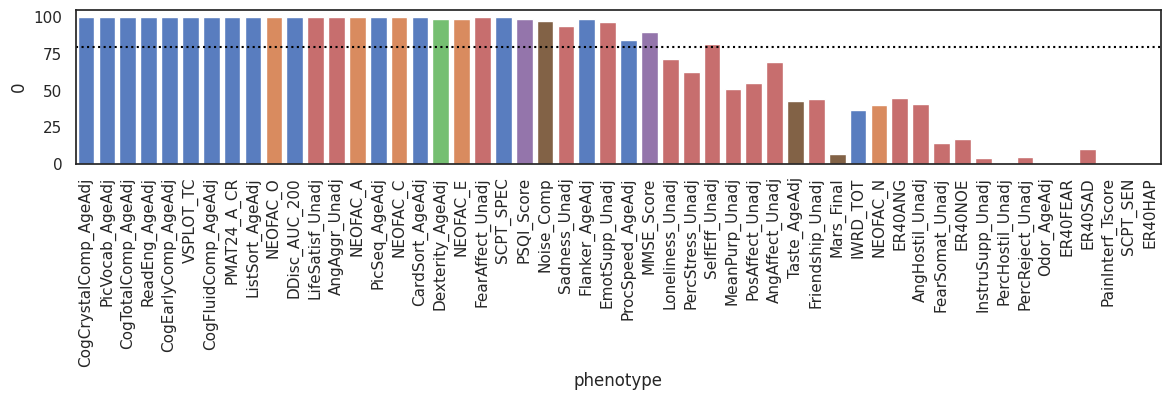

In [8]:
sns.set(rc={"figure.figsize":(14, 2)})
sns.set_style("white")

phenotypes = pd.read_csv('hcp_data/phenotypes-of-interest.csv').iloc[:, 1:]
phenotypes = phenotypes.drop([2,3]) # Age duplicates

def prep(x, alpha=0.05):
    return (x.loc[x['p_discovery_cv']<alpha,'p_replication']<alpha).sum() / (x['p_discovery_cv']<0.05).sum() * 100

df_plot = pd.DataFrame(df[df.connectivity=='netmats_parcor'].groupby('target').apply(prep))

df_plot['r_discovery'] = df[df.connectivity=='netmats_parcor'].groupby('target').mean()['r_discovery_cv']
df_plot = df_plot[df_plot.index!='age']                       
                       
df_plot['category'] = ''
df_plot['phenotype'] = df_plot.index

for i in df_plot.index:
    df_plot.loc[i, 'category'] = phenotypes.loc[phenotypes.columnHeader==i, 'category'].values[0]

                       
df_plot = df_plot.sort_values(by='r_discovery', ascending=False)                      
                       
pal = "muted"
my_colormap = [
              sns.color_palette(pal)[4],
              sns.color_palette(pal)[0], # cognition
              sns.color_palette(pal)[3], # emotion
              sns.color_palette(pal)[2], # dexterity
              sns.color_palette(pal)[1], # big5
              sns.color_palette(pal)[5], # sensory
              sns.color_palette(pal)[6], # ?
              sns.color_palette(pal)[3]]
colors = []
for code in pd.Categorical(df_plot.category).codes:
    colors.append(my_colormap[code])

ax=sns.barplot(data=df_plot, x='phenotype', y=0, palette=colors)
plt.xticks(rotation=90)
ax.axhline(80, color='black', linestyle=':')
plt.savefig('fig/replicability_all_phenotypes.pdf')

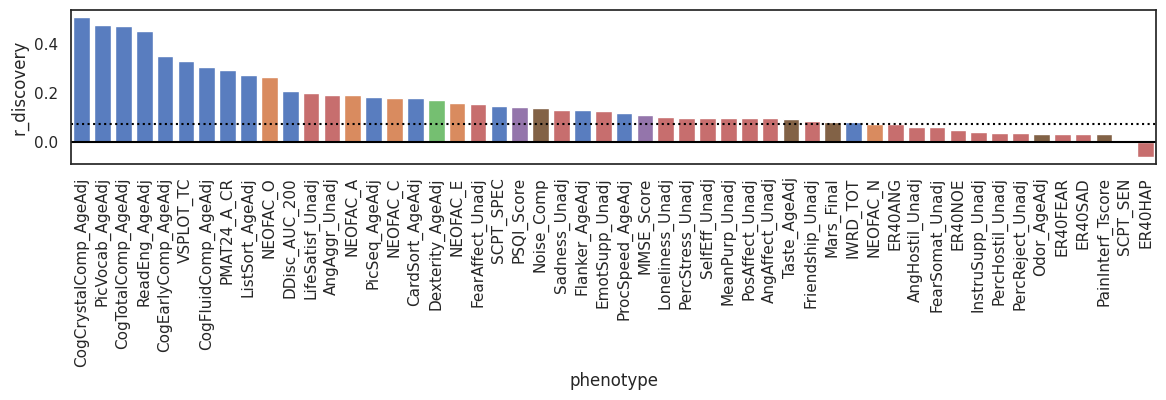

In [9]:
ax=sns.barplot(data=df_plot, x='phenotype', y='r_discovery', palette=colors)
plt.xticks(rotation=90)
ax.axhline(0.074, color='black', linestyle=':') # parametric one-sided significance threshold
ax.axhline(0, color='black')
plt.savefig('fig/r_discovery_all_phenotypes.pdf')

In [26]:
import plotly.express as px

fig = px.bar(df_plot, y=0, x='phenotype', text_auto='.2s',
            title="Replication probability with n=500",
            labels={'0':'$P_{rep}$'},
            hover_data=['category', 'phenotype_long', 'r_discovery'], color='category')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()



In [179]:
import plotly
import plotly.graph_objs as go

colors = ["#de324c","#f4895f","#f8e16f","#95cf92","#9656a2","#369acc"]

cols = [ colors[c] for c in pd.Categorical(df_plot['category']).codes]

df_plot['category'] = pd.Categorical(df_plot['category'])
df_plot['category'].cat.reorder_categories(['Emotion', 'Sensory',  'Motor', 'Alertness', 'Personality',  'Cognition'], inplace= True)
df_plot = df_plot.sort_values(by=['category', 'r_discovery'], ascending=False)

trace1l = go.Scatter( name='',
            x=df_plot['phenotype'].values,
            y=[80] * len(df_plot['phenotype'].values),
            mode='lines',
            line = dict(color='gray', width=1, dash='dash'),
            showlegend=False,
            hovertemplate="Replication threshold"
        )

trace1 = go.Bar(x=df_plot['phenotype'].values,y=df_plot[0].values, name='',
                marker_color=cols, showlegend=False,
                customdata=df_plot.values,
                #texttemplate="%{y:0.0f}%",
                textposition="outside",
                textangle=0,
                textfont_color="gray",
                hovertemplate="<br>".join([
                    "Domain: %{customdata[2]}",
                    "Effect Size: r=%{customdata[1]:.2f}",
                    "Replication Probability: %{customdata[0]:.0f}%",
                    "Description: %{customdata[4]}"
                ])
                #hovertext=pd.Categorical(df_plot['category'])
                )

trace2l = go.Scatter( name='',
            x=df_plot['phenotype'].values,
            y=[0.074] * len(df_plot['phenotype'].values),
            mode='lines',
            line = dict(color='gray', width=1, dash='dash'),
            showlegend=False,
            hovertemplate="Significance threshold",
            visible=False
        )


trace2 = go.Bar(x=df_plot['phenotype'].values,y=df_plot['r_discovery'], visible=False, name='',
                marker_color=cols, showlegend=False,
                customdata=df_plot.values,
                #texttemplate="%{y:0.2f}",
                textposition="outside",
                textangle=0,
                textfont_color="gray",
                hovertemplate="<br>".join([
                    "Domain: %{customdata[2]}",
                    "Effect Size: r=%{customdata[1]:.2f}",
                    "Replication Probability: %{customdata[0]:.0f}%",
                    "Description: %{customdata[4]}"
                ])
                )
data = [trace1l, trace1, trace2l, trace2]

updatemenus = list([
    dict(active=0,
         showactive = True,
         buttons=list([
            dict(label = "Replication Probability",
                 method = "update",
                 args = [{"visible": [True, True, False, False]}]), # hide trace2
            dict(label = "Predictive Effect Size",
                 method = "update",
                 args = [{"visible": [False, False, True, True]}]) # hide trace1
            ]),
         x = 0,
         xanchor = 'left',
         y = 1.5,
         yanchor = 'top',
         )])

layout = dict(title="",
              showlegend=True,
              xaxis=dict(title="Phenotype",
                        showgrid=False, # thin lines in the background
                        #showticklabels=False,  # numbers below),
                        zeroline=True # thick line at x=0
                         ),
              updatemenus=updatemenus,
              template='simple_white',
              font=dict(
                size=10,
                color="gray"),
              autosize=True,
              height=300,
              margin=dict(
              l=5,
              r=5,
              b=10,
              t=10,
              pad=4
    ),
    )

fig=dict(data=data, layout=layout)

#plotly.offline.plot(fig)
#go.Figure(fig).show()
import plotly.io as pio
pio.write_html(fig, file='docs/_includes/figure.html', auto_open=True)

/tmp/ipykernel_36906/85791435.py:9: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.



In [25]:
for i in df_plot.index:
    df_plot.loc[i, 'phenotype_long'] = phenotypes.loc[phenotypes.columnHeader==i, 'fullDisplayName'].values[0]
df_plot

,0,r_discovery,category,phenotype,phenotype_long
target,,,,,
CogCrystalComp_AgeAdj,100.000000,0.509356,Cognition,CogCrystalComp_AgeAdj,NIH Toolbox Cognition Crystallized Composite: ...
PicVocab_AgeAdj,100.000000,0.474802,Cognition,PicVocab_AgeAdj,NIH Toolbox Picture Vocabulary Test: Age-Adjus...
CogTotalComp_AgeAdj,100.000000,0.472652,Cognition,CogTotalComp_AgeAdj,NIH Toolbox Cognition Total Composite Score: A...
ReadEng_AgeAdj,100.000000,0.450867,Cognition,ReadEng_AgeAdj,NIH Toolbox Oral Reading Recognition Test: Age...
CogEarlyComp_AgeAdj,100.000000,0.350107,Cognition,CogEarlyComp_AgeAdj,NIH Toolbox Cognition Early Childhood Composit...
VSPLOT_TC,100.000000,0.330419,Cognition,VSPLOT_TC,Variable Short Penn Line Orientation: Total Nu...
CogFluidComp_AgeAdj,100.000000,0.304980,Cognition,CogFluidComp_AgeAdj,NIH Toolbox Cognition Fluid Composite: Age Adj...
PMAT24_A_CR,100.000000,0.292243,Cognition,PMAT24_A_CR,Penn Progressive Matrices: Number of Correct R...
ListSort_AgeAdj,100.000000,0.272622,Cognition,ListSort_AgeAdj,NIH Toolbox List Sorting Working Memory Test: ...


In [170]:
tmp = behavior[['CogTotalComp_AgeAdj', 'CogFluidComp_AgeAdj', 'PMAT24_A_CR', 'Flanker_AgeAdj', 'CardSort_AgeAdj', 'PicSeq_AgeAdj']]
tmp.corr()

,CogTotalComp_AgeAdj,CogFluidComp_AgeAdj,PMAT24_A_CR,Flanker_AgeAdj,CardSort_AgeAdj,PicSeq_AgeAdj
CogTotalComp_AgeAdj,1.000000,0.844787,0.529659,0.519260,0.568456,0.515942
CogFluidComp_AgeAdj,0.844787,1.000000,0.356512,0.633329,0.689420,0.614940
PMAT24_A_CR,0.529659,0.356512,1.000000,0.130267,0.221504,0.296054
Flanker_AgeAdj,0.519260,0.633329,0.130267,1.000000,0.518264,0.151930
CardSort_AgeAdj,0.568456,0.689420,0.221504,0.518264,1.000000,0.211827
PicSeq_AgeAdj,0.515942,0.614940,0.296054,0.151930,0.211827,1.000000


In [269]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ["Replicable", "Not Replicable"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[15+4+2+1+1, 2+1+0+0+4], name="Trait-like",  marker_colors=['green', 'red'], rotation=180),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=[6, 17], name="State-like", rotation=0),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    template='simple_white',
    title_text="",
    font=dict(
                size=10,
                color="gray"),
    autosize=True,
    height=70,
    width=600,
    margin=dict(
              l=5,
              r=5,
              b=10,
              t=10,
              pad=4),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=-0.4,
        font_color='black'
    ),
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Trait-like', x=0.03, y=-0.1, font_size=12, font_color='black', showarrow=False),
                 dict(text='State-like', x=0.73, y=-0.1, font_size=12, font_color='black', showarrow=False)])
fig.show()
import plotly.io as pio
pio.write_html(fig, file='docs/_includes/pie.html', auto_open=True)